In [4]:
%config ZMQInteractiveShell.ast_node_interactivity='all'
from hiive import mdptoolbox
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning
import gym
import time
import pickle
import os, sys

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
def get_score(env, policy_arr, episodes=1000):
    num_miss = 0
    steps_list = []
    for episode in range(episodes):
        state_idx = env.reset()
        steps=0
        while True:
            action_idx = policy_arr[state_idx]
            state_idx, reward, done, info = env.step(action_idx)
            steps+=1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                num_miss += 1
                break
                
    avg_steps = round(np.mean(steps_list), 0)
    success_rate = 1 - num_miss/episodes  
    
    return avg_steps, success_rate

In [7]:
def show_best_policy(env, policy_arr, strategy="VI"):
    nbr_states = env.nS
    nbr_rows = int(np.sqrt(nbr_states))
    nbr_cols = int(np.sqrt(nbr_states))
    
    dis_map = np.zeros((nbr_rows,nbr_cols))
    desc = env.unwrapped.desc.ravel().astype(str)
    desc = np.char.array(desc)
    desc = desc.reshape(nbr_rows, nbr_cols)
    dis_map[desc=="S"] = 1
    dis_map[desc=="F"] = 1
    dis_map[desc=="H"] = -5
    dis_map[desc=="G"] = 5
    
    action_dict = {0:'\u2190', 1:'\u2193', 2:'\u2192', 3:'\u2191'}
    state_labels = np.vectorize(action_dict.get)(policy_arr)
    state_labels = np.char.array(state_labels)
    state_labels = state_labels.reshape(nbr_rows, nbr_cols)
    
    plt.imshow(dis_map, interpolation="nearest")
    for i in range(nbr_rows):
        for j in range(nbr_cols):
            text = plt.text(j, i, state_labels[i,j], ha="center", va="center", color="w", )
    plt.title(f"Best Result of {strategy}")
    plt.axis("off")
    plt.show()

In [15]:
def plot_policy(env, policy_arrs, iterations):
    
    if len(policy_arrs) == 1:
        rows = 1
        cols = 2
    else:
        rows = len(policy_arrs) // 4
        rows = rows + 1 if len(policy_arrs) % 4 else rows
        cols = 4
        
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3,rows*5)) 
    for iteration, ax, policy_arr in zip(iterations, axes.ravel(), policy_arrs):
        
        nbr_states = env.nS
        nbr_rows = int(np.sqrt(nbr_states))
        nbr_cols = int(np.sqrt(nbr_states))
        
        
        dis_map = np.zeros((nbr_rows,nbr_cols))
        desc = env.unwrapped.desc.ravel().astype(str)
        desc = np.char.array(desc)
        desc = desc.reshape(nbr_rows, nbr_cols)
        dis_map[desc=="S"] = 1
        dis_map[desc=="F"] = 1
        dis_map[desc=="H"] = -5
        dis_map[desc=="G"] = 5
#         print(dis_map)

        action_dict = {0:'\u2190', 1:'\u2193', 2:'\u2192', 3:'\u2191'}
        state_labels = np.vectorize(action_dict.get)(policy_arr)
        state_labels = np.char.array(state_labels)
        state_labels = state_labels.reshape(nbr_rows, nbr_cols)
#         print(state_labels)
        
        ax.imshow(dis_map, interpolation="nearest")
        for i in range(nbr_rows):
            for j in range(nbr_cols):
                text = ax.text(j, i, state_labels[i,j], ha="center", va="center", color="w", )
        ax.title.set_text(f'policy at iteration {iteration}')
        ax.axis("off")
    
    plt.suptitle('Policies against iterations')
    plt.subplots_adjust(top=0.9)
    fig.tight_layout()
    plt.show()

### Generate Problem

In [9]:
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
env = FrozenLakeEnv(map_name='4x4', is_slippery=False)
env.reset()
done = False
def transform(env):
    P = np.zeros((4,env.nS,env.nS))
    R = np.zeros(env.nS,)

    for s in range(env.nS):
        for a in range(4):
            for p, s_, r, _ in env.P[s][a]:
                P[a][s][s_]+=p
                if s!=s_:
                    R[s_]=r
    return P, R

0

In [10]:
arr_trans, arr_reward = transform(env)

### Value iteration

In [11]:
def run_vi(transitions, reward_arr, gamma_list, epsilon_list):
    dict_running_metrics = {}
    best_score, best_id = float("-inf"), -1
    for gamma in gamma_list:
        for epsilon in epsilon_list:
            experiment_id = f'gamma={gamma}_epsilon={epsilon}'
            value_iteration_mdp = mdptoolbox.mdp.ValueIteration(transitions, reward_arr, gamma = gamma, epsilon = epsilon)
            value_iteration_mdp.run()
            state_val_arr = np.asarray(value_iteration_mdp.V)
            policy_arr = np.asarray(value_iteration_mdp.policy)
            iterations_taken = value_iteration_mdp.iter
            time_taken = value_iteration_mdp.time
            avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
            summary = experiment_id + f', Value iteration took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(100*success_rate,2)}% success rate'
            print(summary)

            experiment_dict = {}
            experiment_dict['state_val_arr'] = state_val_arr
            experiment_dict['policy_arr'] = policy_arr
            experiment_dict['iterations_taken'] = iterations_taken
            experiment_dict['time_taken'] = time_taken
            experiment_dict['avg_steps'] = avg_steps
            experiment_dict['score'] = success_rate
            experiment_dict['p_cumulative'] = value_iteration_mdp.p_cumulative
            experiment_dict['error_mean'] = value_iteration_mdp.error_mean
            experiment_dict['run_stats'] = value_iteration_mdp.run_stats
            dict_running_metrics[experiment_id] = experiment_dict

            with open('frozenlake_val_iter_output.txt', 'a') as f:
                f.write(summary)

            with open('frozenlake_val_iter_dict.pickle', 'wb') as handle:
                pickle.dump(dict_running_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)

            if success_rate > best_score:
                best_score = success_rate
                best_id = experiment_id
    return dict_running_metrics, best_id

#### running

In [12]:
vi_lst_gamma=[0.5, 0.75, 0.9, 0.95, 0.99]
vi_lst_eps=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15]
    
res_vi_dict, res_vi_best_id = run_vi(arr_trans, arr_reward, vi_lst_gamma, vi_lst_eps)

gamma=0.5_epsilon=0.001, Value iteration took 10 iterations and 0.00217 seconds, achieved 100.0% success rate
gamma=0.5_epsilon=1e-06, Value iteration took 20 iterations and 0.00101 seconds, achieved 100.0% success rate
gamma=0.5_epsilon=1e-09, Value iteration took 30 iterations and 0.00161 seconds, achieved 100.0% success rate
gamma=0.5_epsilon=1e-12, Value iteration took 40 iterations and 0.00215 seconds, achieved 100.0% success rate
gamma=0.5_epsilon=1e-15, Value iteration took 50 iterations and 0.00264 seconds, achieved 100.0% success rate
gamma=0.75_epsilon=0.001, Value iteration took 28 iterations and 0.00161 seconds, achieved 100.0% success rate
gamma=0.75_epsilon=1e-06, Value iteration took 52 iterations and 0.00265 seconds, achieved 100.0% success rate
gamma=0.75_epsilon=1e-09, Value iteration took 76 iterations and 0.00383 seconds, achieved 100.0% success rate
gamma=0.75_epsilon=1e-12, Value iteration took 100 iterations and 0.00523 seconds, achieved 100.0% success rate
gamma

#### visualization

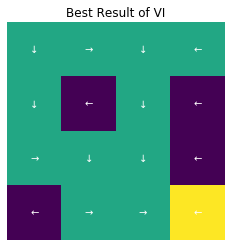

Best parameter settings: gamma=0.5_epsilon=0.001


In [13]:
# show best 
show_best_policy(env, res_vi_dict[res_vi_best_id]["policy_arr"], "VI")
print("Best parameter settings:", res_vi_best_id)

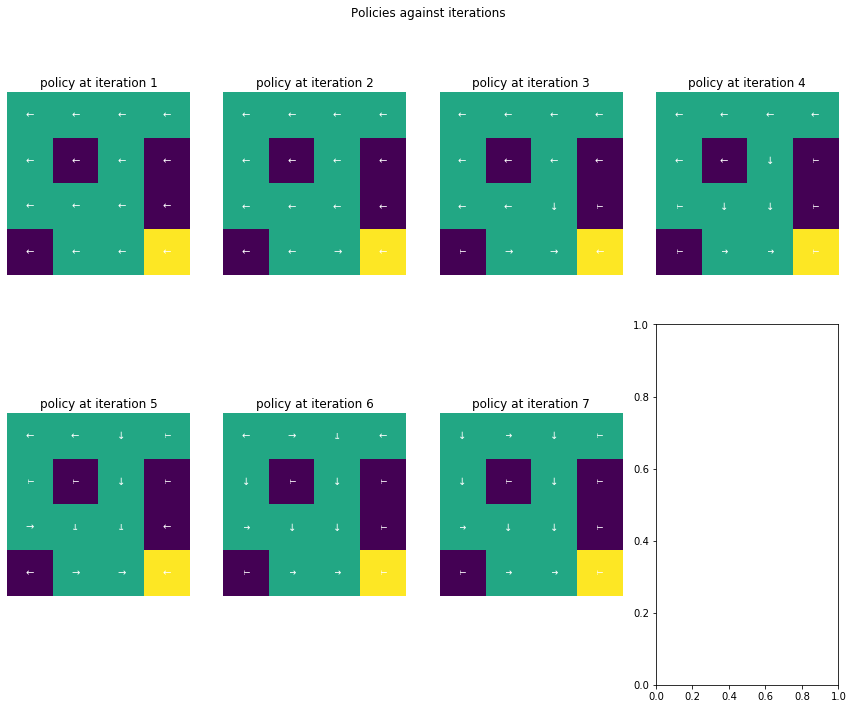

In [16]:
# show iterations of policies
p_cumulative = res_vi_dict[res_vi_best_id]['p_cumulative']

length = len(p_cumulative)
every_n = 1 if length // 10 == 0 else length // 10
iterations, policy_arrs = [], []
for idx, p_cum in enumerate(p_cumulative):
    if idx % every_n > 0:
        continue
    iterations.append(p_cum[0])
    policy_arrs.append(p_cum[1])
plot_policy(env, policy_arrs, iterations)

#### performance

In [47]:
def plot_performance_eps(res_vi_dict, epsilon_list, best_gamma):
    graphs = ['iterations_taken', 'time_taken', 'avg_steps', 'score']
    variables_dict = {graph:[] for graph in graphs}
    
    for gamma in [best_gamma]:
        for epsilon in epsilon_list:
            experiment_id = f'gamma={gamma}_epsilon={epsilon}'
            for graph in graphs:
                variables_dict[graph].append(res_vi_dict[experiment_id][graph])

    fig, axes = plt.subplots(2,2, figsize=(15,10))
    for ax, graph in zip(axes.ravel(), graphs):
        ax.plot(epsilon_list, variables_dict[graph], label=graph, lw=2)
        ax.title.set_text(f'{graph} vs epsilon')
        ax.set_xlabel('epsilon')
        ax.set_ylabel(graph)
        ax.grid()

    fig.tight_layout()
    plt.suptitle('Varying epsilons for value iterations')
    plt.subplots_adjust(top=0.9)
    plt.show();

In [48]:
res_vi_best_id

'gamma=0.99_epsilon=0.001'

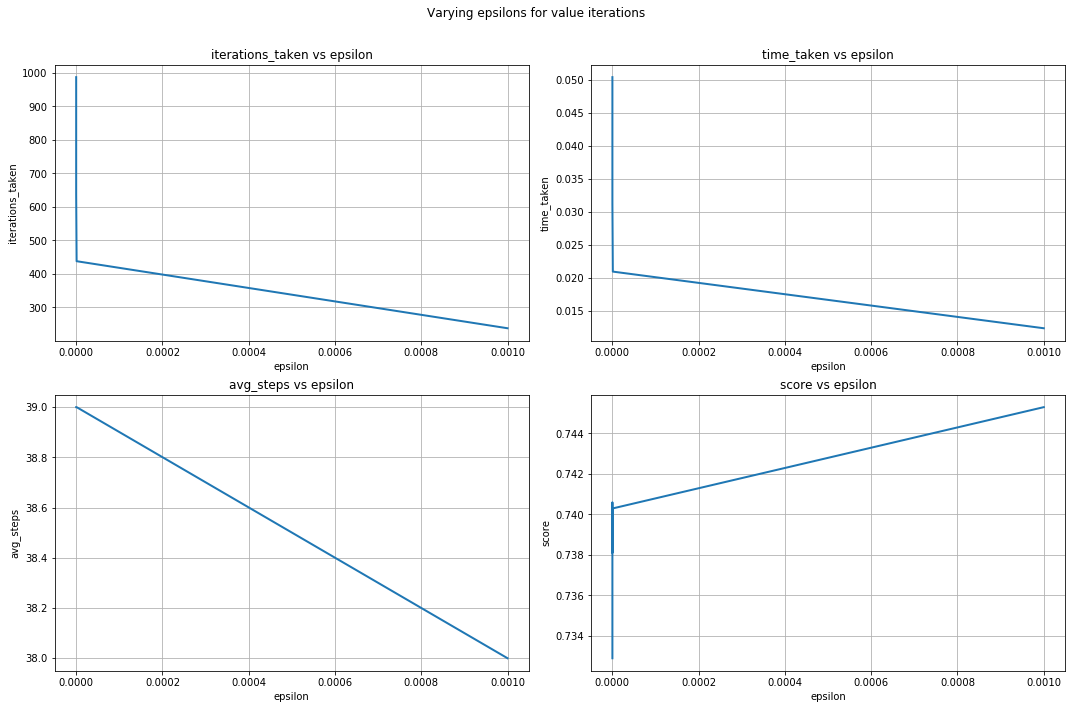

In [49]:
plot_performance_eps(res_vi_dict, vi_lst_eps, 0.99)

In [53]:
def plot_performance_gamma(res_vi_dict, gamma_list, best_eps):    
    graphs = ['iterations_taken', 'time_taken', 'avg_steps', 'score']
    variables_dict = {graph:[] for graph in graphs}
    for gamma in gamma_list:
        for epsilon in [best_eps]:
            experiment_id = f'gamma={gamma}_epsilon={epsilon}'
            for graph in graphs:
                variables_dict[graph].append(res_vi_dict[experiment_id][graph])

    fig, axes = plt.subplots(2,2, figsize=(15,10))
    for ax, graph in zip(axes.ravel(), graphs):
        ax.plot(gamma_list, variables_dict[graph], label=graph)
        ax.title.set_text(f'{graph} vs gamma')
        ax.set_xlabel('gamma')
        ax.set_ylabel(graph)
        ax.grid()

    fig.tight_layout()
    plt.suptitle('Varying gamma for value iterations')
    plt.subplots_adjust(top=0.9)
    plt.show();

In [54]:
res_vi_best_id

'gamma=0.99_epsilon=0.001'

In [56]:
plot_performance_gamma(res_vi_dict, vi_lst_gamma, 0.001);

### Policy iteration

#### running

In [57]:
def run_pi(transitions, reward_arr, gamma_list):
    dict_running_metrics = {}
    best_score, best_params = float("-inf"), -1
    for gamma in gamma_list:
        experiment_id = f'gamma={gamma}'

        policy_iteration_mdp = mdptoolbox.mdp.PolicyIteration(transitions, reward_arr, gamma = gamma)
        policy_iteration_mdp.run()
        state_val_arr = np.asarray(policy_iteration_mdp.V)
        policy_arr = np.asarray(policy_iteration_mdp.policy)
        iterations_taken = policy_iteration_mdp.iter
        time_taken = policy_iteration_mdp.time
        avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
    #     plot_policy(env, policy_arr)
        summary = experiment_id + f', Policy iteration took {iterations_taken} iterations and {round(time_taken, 5)} seconds, achieved {round(100*success_rate,2)}% success rate'
        print(summary)

        experiment_dict = {}
        experiment_dict['state_val_arr'] = state_val_arr
        experiment_dict['policy_arr'] = policy_arr
        experiment_dict['iterations_taken'] = iterations_taken
        experiment_dict['time_taken'] = time_taken
        experiment_dict['avg_steps'] = avg_steps
        experiment_dict['score'] = success_rate
        experiment_dict['p_cumulative'] = policy_iteration_mdp.p_cumulative
        experiment_dict['error_mean'] = policy_iteration_mdp.error_mean
        experiment_dict['run_stats'] = policy_iteration_mdp.run_stats
        dict_running_metrics[experiment_id] = experiment_dict

        if success_rate > best_score:
            best_score = success_rate
            best_params = experiment_id
    return dict_running_metrics, best_params

In [59]:
pi_lst_gamma=[0.5, 0.75, 0.9, 0.95, 0.99]
res_pi_dict, res_pi_best_id = run_pi(arr_trans, arr_reward, pi_lst_gamma)

gamma=0.5, Policy iteration took 4 iterations and 0.00335 seconds, achieved 44.0% success rate
gamma=0.75, Policy iteration took 4 iterations and 0.00153 seconds, achieved 44.13% success rate
gamma=0.9, Policy iteration took 6 iterations and 0.00242 seconds, achieved 73.83% success rate
gamma=0.95, Policy iteration took 5 iterations and 0.00244 seconds, achieved 72.5% success rate
gamma=0.99, Policy iteration took 1000 iterations and 0.30418 seconds, achieved 74.3% success rate


#### visualization

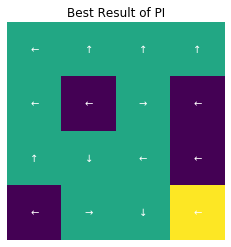

Best parameter settings: gamma=0.99


In [60]:
# show best 
show_best_policy(env, res_pi_dict[res_pi_best_id]["policy_arr"], "PI")
print("Best parameter settings:", res_pi_best_id)

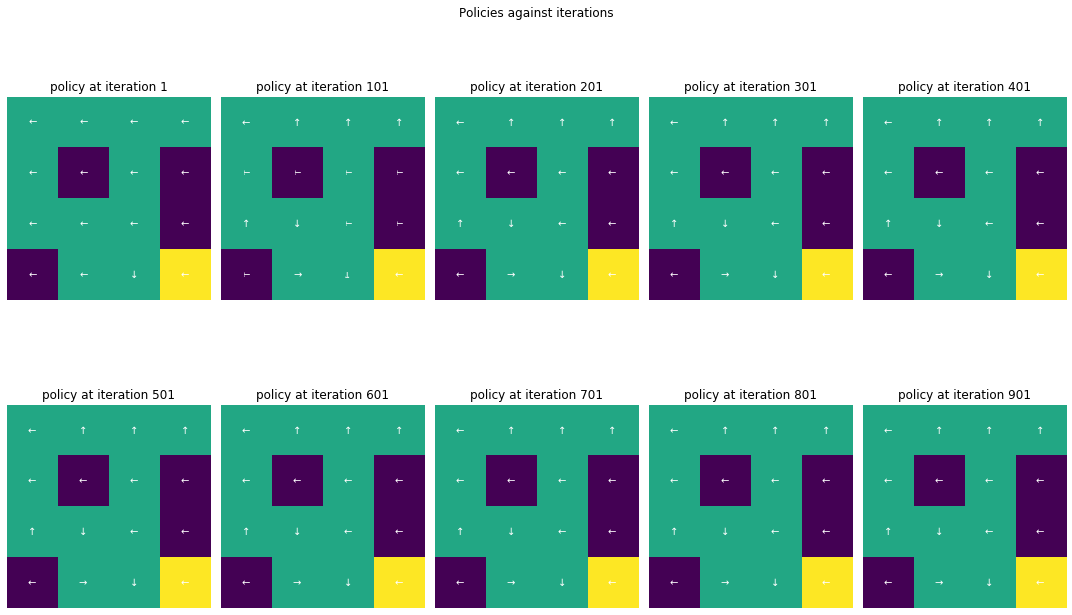

In [61]:
# show iterations of policies
p_cumulative = res_pi_dict[res_pi_best_id]['p_cumulative']

length = len(p_cumulative)
every_n = 1 if length // 10 == 0 else length // 10
iterations, policy_arrs = [], []
for idx, p_cum in enumerate(p_cumulative):
    if idx % every_n > 0:
        continue
    iterations.append(p_cum[0])
    policy_arrs.append(p_cum[1])
plot_policy(env, policy_arrs, iterations)

#### performance

In [70]:
def plot_performance_gamma_pi(res_pi_dict, gamma_list):    
    graphs = ['iterations_taken', 'time_taken', 'avg_steps', 'score']
    variables_dict = {graph:[] for graph in graphs}
    for gamma in gamma_list:
        experiment_id = f'gamma={gamma}'
        for graph in graphs:
            variables_dict[graph].append(res_pi_dict[experiment_id][graph])

    fig, axes = plt.subplots(2,2, figsize=(15,10))
    for ax, graph in zip(axes.ravel(), graphs):
        ax.plot(gamma_list, variables_dict[graph], label=graph)
        ax.title.set_text(f'{graph} vs gamma')
        ax.set_xlabel('gamma')
        ax.set_ylabel(graph)
        ax.grid()

    fig.tight_layout()
    plt.suptitle('Varying gamma for policy iterations')
    plt.subplots_adjust(top=0.9)
    plt.show();

In [71]:
plot_performance_gamma_pi(res_pi_dict, pi_lst_gamma)

### Q-learning

In [100]:
def run_ql(transitions, reward_arr, gamma_list, alpha_list, n_iter_list):
    qlearning_perf_dict = {}
    best_score = 0
    for alpha in alpha_list:
        for gamma in gamma_list:
            for n_iter in n_iter_list:
                experiment_id = f'gamma={gamma}_n_iter={n_iter}'
                qlearning_mdp = mdptoolbox.mdp.QLearning(transitions, reward_arr, 
                                                         gamma = gamma, 
                                                         alpha = alpha,
                                                         n_iter = n_iter)
                qlearning_mdp.run()
                state_val_arr = np.asarray(qlearning_mdp.V)
                policy_arr = np.asarray(qlearning_mdp.policy)
                time_taken = qlearning_mdp.time
                avg_steps, success_rate = get_score(env, policy_arr, episodes = 10000)
                summary = experiment_id + f', Qlearning took {n_iter} iterations and {round(time_taken, 5)} seconds, achieved {round(100*success_rate,2)}% success rate'
                print(summary)

                experiment_dict = {}
                experiment_dict['state_val_arr'] = state_val_arr
                experiment_dict['policy_arr'] = policy_arr
                experiment_dict['iterations_taken'] = n_iter
                experiment_dict['time_taken'] = time_taken
                experiment_dict['avg_steps'] = avg_steps
                experiment_dict['score'] = success_rate
                experiment_dict['p_cumulative'] = qlearning_mdp.p_cumulative
                experiment_dict['error_mean'] = qlearning_mdp.error_mean
                experiment_dict['run_stats'] = qlearning_mdp.run_stats
                qlearning_perf_dict[experiment_id] = experiment_dict

                if success_rate > best_score:
                    best_score = success_rate
                    best_params = experiment_id
    return qlearning_perf_dict, best_params

#### running

In [101]:
ql_lst_gamma = [0.5, 0.75, 0.9, 0.95, 0.99]
ql_lst_alpha = [0.1] # [0.1, 0.01]
ql_lst_n_iter = [1e4, 5e4, 1e5, 5e5, 1e6]

In [102]:
res_ql_dict, res_ql_best_id = run_ql(arr_trans, arr_reward, ql_lst_gamma, ql_lst_alpha, ql_lst_n_iter)

gamma=0.5_n_iter=10000.0, Qlearning took 10000.0 iterations and 0.46648 seconds, achieved 0.0% success rate
gamma=0.5_n_iter=50000.0, Qlearning took 50000.0 iterations and 1.9923 seconds, achieved 8.06% success rate
gamma=0.5_n_iter=100000.0, Qlearning took 100000.0 iterations and 4.0506 seconds, achieved 11.54% success rate
gamma=0.5_n_iter=500000.0, Qlearning took 500000.0 iterations and 18.92712 seconds, achieved 4.01% success rate
gamma=0.5_n_iter=1000000.0, Qlearning took 1000000.0 iterations and 39.13654 seconds, achieved 10.77% success rate
gamma=0.75_n_iter=10000.0, Qlearning took 10000.0 iterations and 0.473 seconds, achieved 0.0% success rate
gamma=0.75_n_iter=50000.0, Qlearning took 50000.0 iterations and 2.00889 seconds, achieved 5.34% success rate
gamma=0.75_n_iter=100000.0, Qlearning took 100000.0 iterations and 3.91296 seconds, achieved 4.49% success rate
gamma=0.75_n_iter=500000.0, Qlearning took 500000.0 iterations and 19.1823 seconds, achieved 16.77% success rate
gamm

#### visualization

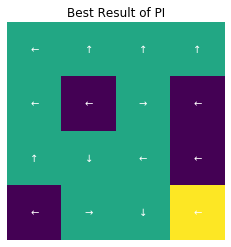

Best parameter settings: gamma=0.99


In [96]:
# show best 
show_best_policy(env, res_pi_dict[res_pi_best_id]["policy_arr"], "PI")
print("Best parameter settings:", res_pi_best_id)

#### performance

In [103]:
res_ql_best_id
res_ql_dict

'gamma=0.95_n_iter=500000.0'

In [105]:
def plot_performance_ql_gamma(res_ql_dict, gamma_list, best_iter):
    graphs = ['time_taken', 'avg_steps', 'score']
    variables_dict = {graph:[] for graph in graphs}
    for gamma in gamma_list:
        for n_iter in [best_iter]:
            experiment_id = f'gamma={gamma}_n_iter={n_iter}'
            for graph in graphs:
                variables_dict[graph].append(res_ql_dict[experiment_id][graph])

    fig, axes = plt.subplots(1,3, figsize=(15,5))
    for ax, graph in zip(axes.ravel(), graphs):
        ax.plot(gamma_list, variables_dict[graph], label=graph, lw=2)
        ax.title.set_text(f'{graph} vs gamma')
        ax.set_xlabel('gamma')
        ax.set_ylabel(graph)
        ax.grid()

    fig.tight_layout()
    plt.suptitle('Varying gamma for Qlearning')
    plt.subplots_adjust(top=0.9)
    plt.show();

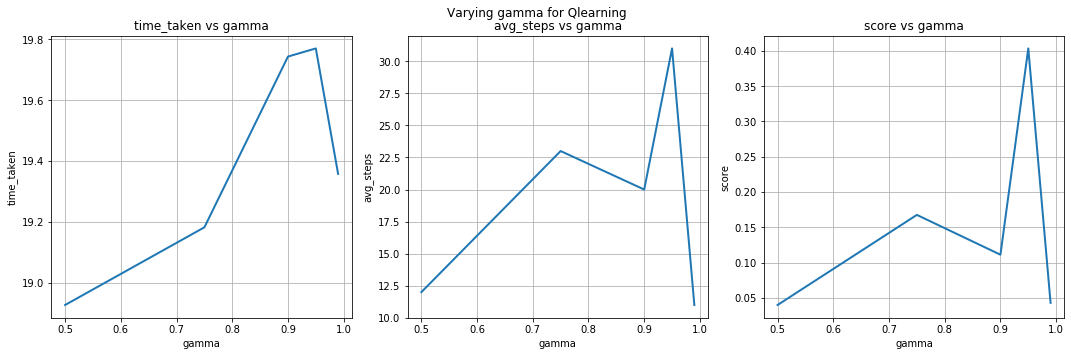

In [108]:
plot_performance_ql_gamma(res_ql_dict, ql_lst_gamma, 500000.0);

In [109]:
def plot_performance_ql_iter(res_ql_dict, n_iter_list, best_gamma):
    graphs = ['time_taken', 'avg_steps', 'score']
    variables_dict = {graph:[] for graph in graphs}
    for gamma in [best_gamma]:
        for n_iter in n_iter_list:
            experiment_id = f'gamma={gamma}_n_iter={n_iter}'
            for graph in graphs:
                variables_dict[graph].append(res_ql_dict[experiment_id][graph])

    fig, axes = plt.subplots(1,3, figsize=(15,5))
    for ax, graph in zip(axes.ravel(), graphs):
        ax.plot(n_iter_list, variables_dict[graph], label=graph)
        ax.title.set_text(f'{graph} vs n_iter')
        ax.set_xlabel('n_iter')
        ax.set_ylabel(graph)
        ax.grid()

    fig.tight_layout()
    plt.suptitle('Varying number of iterations for Qlearning')
    plt.subplots_adjust(top=0.9)
    plt.show();

In [111]:
res_ql_best_id

'gamma=0.95_n_iter=500000.0'

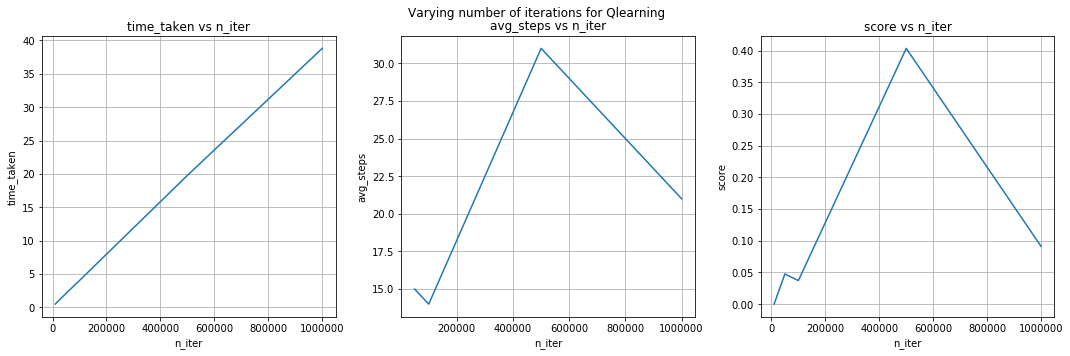

In [112]:
plot_performance_ql_iter(res_ql_dict, ql_lst_n_iter, 0.95);